In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   carbonia
   2   cagliari
   3   alessandria
   4   caltanissetta
   5   cremona
   6   brindisi
   7   pesaro
   8   trapani
   9   cuneo
   10   siracusa
   11   cosenza
   12   roma
   13   campobasso
   14   savona
   15   verona
   16   reggio_nell_emilia
   17   livorno
   18   vercelli
   19   udine
   20   nuoro
   21   perugia
   22   varese
   23   torino
   24   gorizia
   25   ferrara
   26   sassari
   27   crotone
   28   imperia
   29   bat
   30   ravenna
   31   massa
   32   padova
   33   vicenza
   34   asti
   35   bari
   36   verbania
   37   grosseto
   38   taranto
   39   matera
   40   salerno
   41   lodi
   42   trento
   43   treviso
   44   napoli
   45   viterbo
   46   macerata
   47   modena
   48   bergamo
   49   bologna
   50   catania
   51   brescia
   52   siena
   53   foggia
   54   reggio_di_calabria
   55   avellino
   56   ascoli_piceno
   57   biella
   58   com

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 cagliari
2 alessandria
3 caltanissetta
4 cremona
5 brindisi
6 pesaro
7 trapani
8 cuneo
9 siracusa
10 cosenza
11 roma
12 campobasso
13 savona
14 verona
15 reggio_nell_emilia
16 livorno
17 vercelli
18 udine
19 nuoro
20 perugia
21 varese
22 torino
23 gorizia
24 ferrara
25 sassari
26 crotone
27 imperia
28 bat
29 ravenna
30 massa
31 padova
32 vicenza
33 asti
34 bari
35 verbania
36 grosseto
37 taranto
38 matera
39 salerno
40 lodi
41 trento
42 treviso
43 napoli
44 viterbo
45 macerata
46 modena
47 bergamo
48 bologna
49 catania
50 brescia
51 siena
52 foggia
53 reggio_di_calabria
54 avellino
55 ascoli_piceno
56 biella
57 como
58 trieste
59 piacenza
60 parma
61 firenze
62 rimini
63 latina
64 l_aquila
65 catanzaro
66 rovigo
67 agrigento
68 milano
69 messina
70 ragusa
71 lucca
72 benevento
73 rieti
74 forli
75 vibo_valentia
76 mantova
77 lecce
78 pavia
79 pordenone
80 potenza
81 sondrio
82 bolzano
83 belluno
84 enna
85 pescara
86 terni
87 pistoia
88 caserta
89 teramo
90 frosinone
91 prato
92 nova

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35444  0.02550 
    Test set average RMSE:  0.92646  0.10661 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35207
                       R2:  0.94328


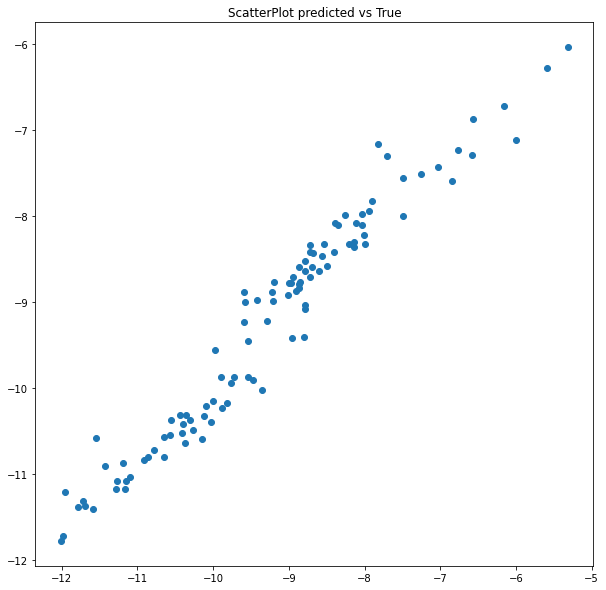

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02238
Feature:               commutersdensity, Score: 0.01088
Feature:                         depriv, Score: 0.02344
Feature:                            lat, Score: 0.64814
Feature:                 Ratio0200ver65, Score: 0.05339
Feature:           avg_wco_period1_2020, Score: 0.03570
Feature:          avg_wnh3_period1_2020, Score: 0.06883
Feature:           avg_wno_period1_2020, Score: 0.04250
Feature:           avg_wo3_period1_2020, Score: 0.04309
Feature:         avg_wpans_period1_2020, Score: 0.02546
Feature:          avg_wso2_period1_2020, Score: 0.02620


<Figure size 432x288 with 0 Axes>

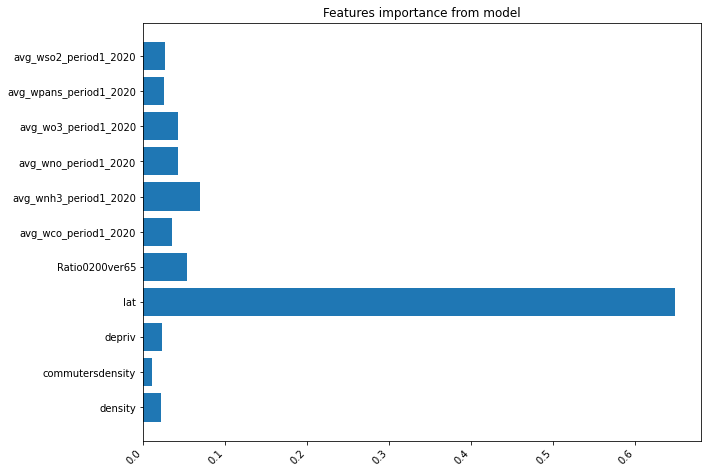

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.03828
Feature:               commutersdensity, Score: 0.02254
Feature:                         depriv, Score: 0.04681
Feature:                            lat, Score: 2.79306
Feature:                 Ratio0200ver65, Score: 0.11501
Feature:           avg_wco_period1_2020, Score: 0.08345
Feature:          avg_wnh3_period1_2020, Score: 0.17082
Feature:           avg_wno_period1_2020, Score: 0.10825
Feature:           avg_wo3_period1_2020, Score: 0.08205
Feature:         avg_wpans_period1_2020, Score: 0.05951
Feature:          avg_wso2_period1_2020, Score: 0.05613


<Figure size 432x288 with 0 Axes>

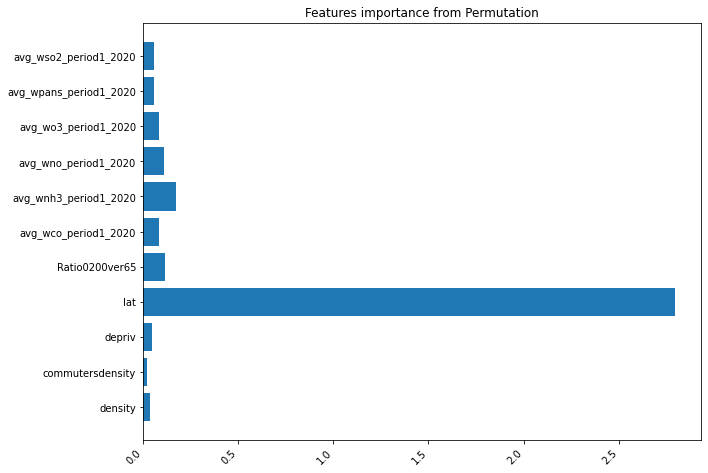

<Figure size 720x720 with 0 Axes>

((0.35444350350527287, 0.025504620853707142),
 (0.9264589224576043, 0.10660739103422591),
 0.3520653282136612,
 {'density': 0.010704681673195297,
  'commutersdensity': 0.006302244506913312,
  'depriv': 0.013090765371704983,
  'lat': 0.7810779628274052,
  'Ratio0200ver65': 0.03216294658684399,
  'avg_wco_period1_2020': 0.02333682440807354,
  'avg_wnh3_period1_2020': 0.04776891993456641,
  'avg_wno_period1_2020': 0.030272956097906627,
  'avg_wo3_period1_2020': 0.022944798443715917,
  'avg_wpans_period1_2020': 0.01664188514136887,
  'avg_wso2_period1_2020': 0.015696015008305742})

<Figure size 432x288 with 0 Axes>

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures", showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.123949995330193
2  of  1200 MSE:  0.12072473141961315
3  of  1200 MSE:  0.17269739797086978
4  of  1200 MSE:  0.21738870494770432
5  of  1200 MSE:  0.4098879925042663
6  of  1200 MSE:  0.48537357315139135
7  of  1200 MSE:  0.5811658429153663
8  of  1200 MSE:  0.6749022786961743
9  of  1200 MSE:  0.16703078348580086
10  of  1200 MSE:  0.19333811592107228
11  of  1200 MSE:  0.1910887671395547
12  of  1200 MSE:  0.23941874212326486
13  of  1200 MSE:  0.4098879925042663
14  of  1200 MSE:  0.48537357315139135
15  of  1200 MSE:  0.5811658429153663
16  of  1200 MSE:  0.6749022786961743
17  of  1200 MSE:  0.2721484465070511
18  of  1200 MSE:  0.3309588066480926
19  of  1200 MSE:  0.2965515188009009
20  of  1200 MSE:  0.3645702067490566
21  of  1200 MSE:  0.4098879925042663
22  of  1200 MSE:  0.48537357315139135
23  of  1200 MSE:  0.5811658429153663
24  of  1200 MSE:  0.6749022786961743
25  of  1200 MSE:  0.37815670753616126
26  of  1200 MSE:  0.436994143471263
27  of  1200 

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200,
 'random_state': 1}
Training set average RMSE:  0.33790  0.02147 
    Test set average RMSE:  0.93559  0.09773 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.33256
                       R2:  0.94939


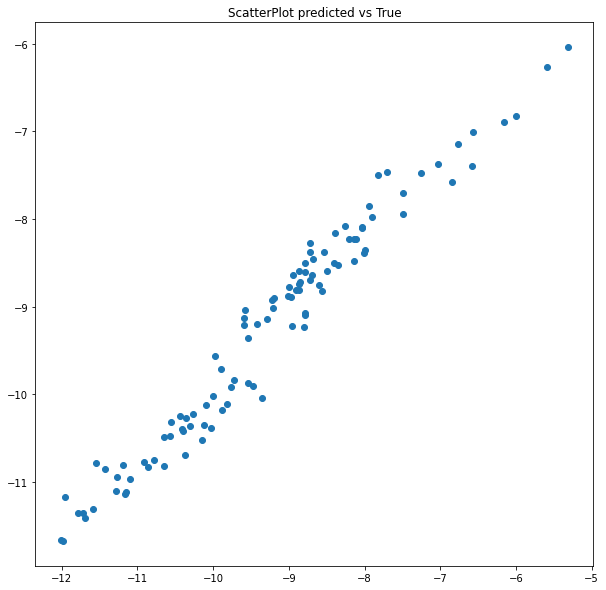

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03120
Feature:               commutersdensity, Score: 0.15154
Feature:                         depriv, Score: 0.07949
Feature:                            lat, Score: 0.26091
Feature:                 Ratio0200ver65, Score: 0.04940
Feature:           avg_wco_period1_2020, Score: 0.09783
Feature:          avg_wnh3_period1_2020, Score: 0.07545
Feature:           avg_wno_period1_2020, Score: 0.11431
Feature:           avg_wo3_period1_2020, Score: 0.06923
Feature:         avg_wpans_period1_2020, Score: 0.03335
Feature:          avg_wso2_period1_2020, Score: 0.03728


<Figure size 432x288 with 0 Axes>

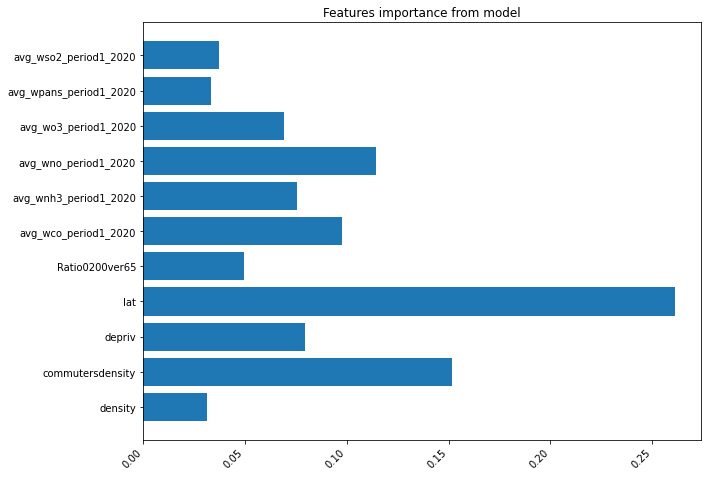

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04693
Feature:               commutersdensity, Score: 0.02308
Feature:                         depriv, Score: 0.03865
Feature:                            lat, Score: 2.62364
Feature:                 Ratio0200ver65, Score: 0.12344
Feature:           avg_wco_period1_2020, Score: 0.07360
Feature:          avg_wnh3_period1_2020, Score: 0.18842
Feature:           avg_wno_period1_2020, Score: 0.10323
Feature:           avg_wo3_period1_2020, Score: 0.08235
Feature:         avg_wpans_period1_2020, Score: 0.06172
Feature:          avg_wso2_period1_2020, Score: 0.06074


<Figure size 432x288 with 0 Axes>

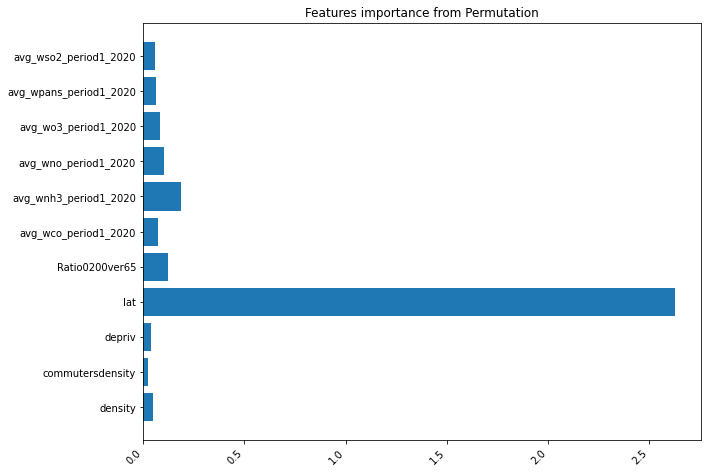

<Figure size 720x720 with 0 Axes>

((0.3379009847476748, 0.021473003972196775),
 (0.9355923736841397, 0.09772977179660876),
 0.3325614434063224,
 {'density': 0.013700387290458735,
  'commutersdensity': 0.006737962818082079,
  'depriv': 0.011282232445568863,
  'lat': 0.765844378491723,
  'Ratio0200ver65': 0.03603323079019918,
  'avg_wco_period1_2020': 0.021483321174183497,
  'avg_wnh3_period1_2020': 0.05500007092946697,
  'avg_wno_period1_2020': 0.03013326348014263,
  'avg_wo3_period1_2020': 0.024037903504852243,
  'avg_wpans_period1_2020': 0.01801638601518125,
  'avg_wso2_period1_2020': 0.017730863060141613})

<Figure size 432x288 with 0 Axes>

In [7]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.38070  0.02730 
    Test set average RMSE:  1.01127  0.10340 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.38210
                       R2:  0.93319


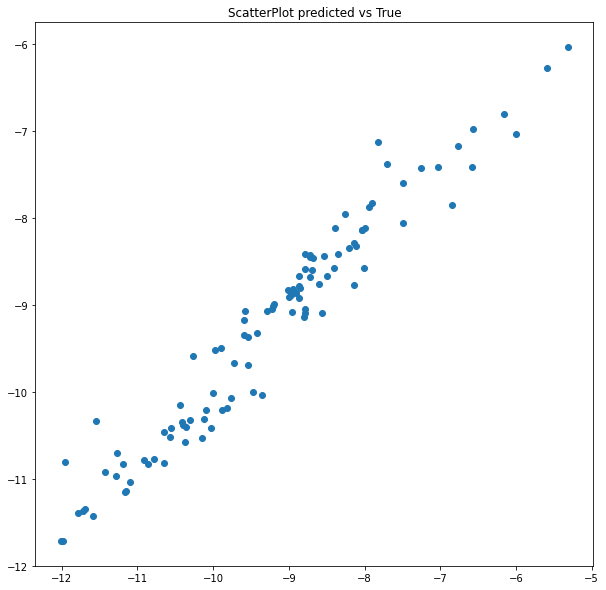

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02710
Feature:               commutersdensity, Score: 0.51368
Feature:                         depriv, Score: 0.02906
Feature:                 Ratio0200ver65, Score: 0.09156
Feature:           avg_wco_period1_2020, Score: 0.05690
Feature:          avg_wnh3_period1_2020, Score: 0.07352
Feature:           avg_wno_period1_2020, Score: 0.08137
Feature:           avg_wo3_period1_2020, Score: 0.05252
Feature:         avg_wpans_period1_2020, Score: 0.03576
Feature:          avg_wso2_period1_2020, Score: 0.03853


<Figure size 432x288 with 0 Axes>

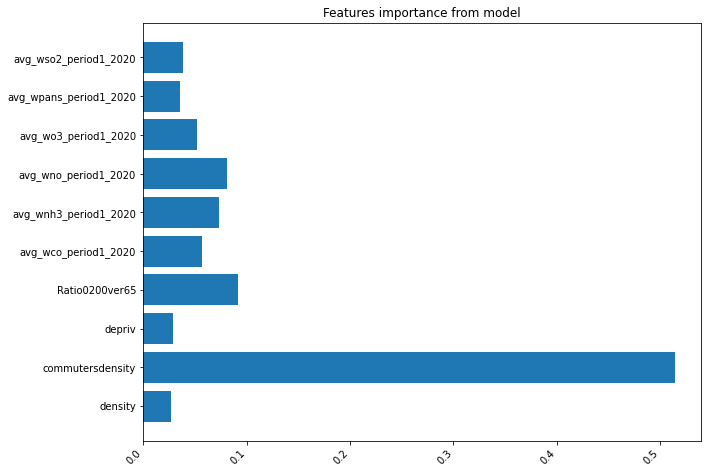

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.03601
Feature:               commutersdensity, Score: 1.59304
Feature:                         depriv, Score: 0.05566
Feature:                 Ratio0200ver65, Score: 0.21592
Feature:           avg_wco_period1_2020, Score: 0.16638
Feature:          avg_wnh3_period1_2020, Score: 0.24861
Feature:           avg_wno_period1_2020, Score: 0.14934
Feature:           avg_wo3_period1_2020, Score: 0.09953
Feature:         avg_wpans_period1_2020, Score: 0.09117
Feature:          avg_wso2_period1_2020, Score: 0.07479


<Figure size 432x288 with 0 Axes>

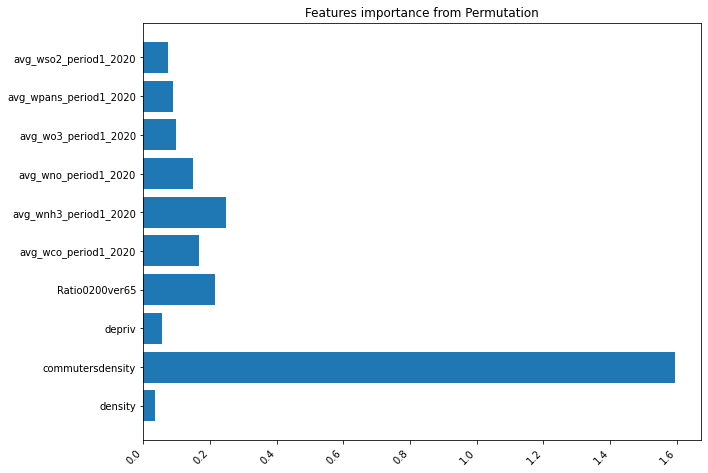

<Figure size 720x720 with 0 Axes>

((0.3807047467346948, 0.027304256759825812),
 (1.0112651770579455, 0.10340388983234393),
 0.38209646510619966,
 {'density': 0.013187113362048569,
  'commutersdensity': 0.5834344647347409,
  'depriv': 0.02038668932423421,
  'Ratio0200ver65': 0.07907872370905004,
  'avg_wco_period1_2020': 0.06093658208897641,
  'avg_wnh3_period1_2020': 0.0910519672490562,
  'avg_wno_period1_2020': 0.05469564446133173,
  'avg_wo3_period1_2020': 0.03645009690449301,
  'avg_wpans_period1_2020': 0.03338862604744352,
  'avg_wso2_period1_2020': 0.02739009211862533})

<Figure size 432x288 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat", pout=sys.stdout, showplot=True)

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.14599770864665323
2  of  1200 MSE:  0.1403008183602389
3  of  1200 MSE:  0.2190505740494816
4  of  1200 MSE:  0.24956871180806545
5  of  1200 MSE:  0.4883858395201539
6  of  1200 MSE:  0.57223871343246
7  of  1200 MSE:  0.7221912406333963
8  of  1200 MSE:  0.7797958389223757
9  of  1200 MSE:  0.19709332194037202
10  of  1200 MSE:  0.21987157832584092
11  of  1200 MSE:  0.23823754658958368
12  of  1200 MSE:  0.2821509492966269
13  of  1200 MSE:  0.4883858395201539
14  of  1200 MSE:  0.57223871343246
15  of  1200 MSE:  0.7221912406333963
16  of  1200 MSE:  0.7797958389223757
17  of  1200 MSE:  0.3260915897847826
18  of  1200 MSE:  0.36721344658954885
19  of  1200 MSE:  0.35984150502171136
20  of  1200 MSE:  0.4207892249140495
21  of  1200 MSE:  0.4883858395201539
22  of  1200 MSE:  0.57223871343246
23  of  1200 MSE:  0.7221912406333963
24  of  1200 MSE:  0.7797958389223757
25  of  1200 MSE:  0.4530030516920153
26  of  1200 MSE:  0.5056767190770345
27  of  1200 MSE:  0

Training set average RMSE:  0.36039  0.02103 
    Test set average RMSE:  1.02081  0.08891 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35621
                       R2:  0.94193


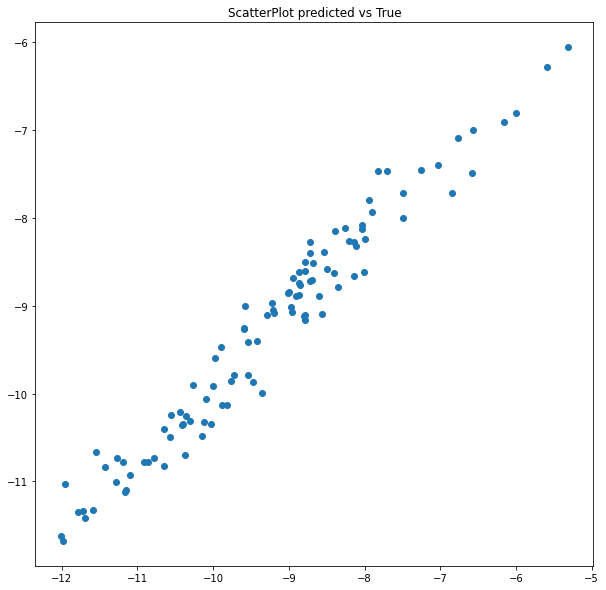

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03747
Feature:               commutersdensity, Score: 0.23557
Feature:                         depriv, Score: 0.10793
Feature:                 Ratio0200ver65, Score: 0.06310
Feature:           avg_wco_period1_2020, Score: 0.12524
Feature:          avg_wnh3_period1_2020, Score: 0.09473
Feature:           avg_wno_period1_2020, Score: 0.15650
Feature:           avg_wo3_period1_2020, Score: 0.08621
Feature:         avg_wpans_period1_2020, Score: 0.04294
Feature:          avg_wso2_period1_2020, Score: 0.05031


<Figure size 432x288 with 0 Axes>

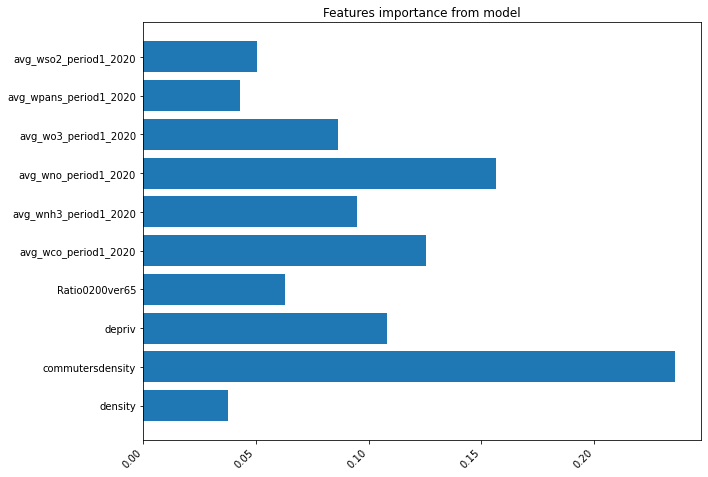

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04279
Feature:               commutersdensity, Score: 1.60507
Feature:                         depriv, Score: 0.06700
Feature:                 Ratio0200ver65, Score: 0.19968
Feature:           avg_wco_period1_2020, Score: 0.15904
Feature:          avg_wnh3_period1_2020, Score: 0.19006
Feature:           avg_wno_period1_2020, Score: 0.16019
Feature:           avg_wo3_period1_2020, Score: 0.10932
Feature:         avg_wpans_period1_2020, Score: 0.09353
Feature:          avg_wso2_period1_2020, Score: 0.07538


<Figure size 432x288 with 0 Axes>

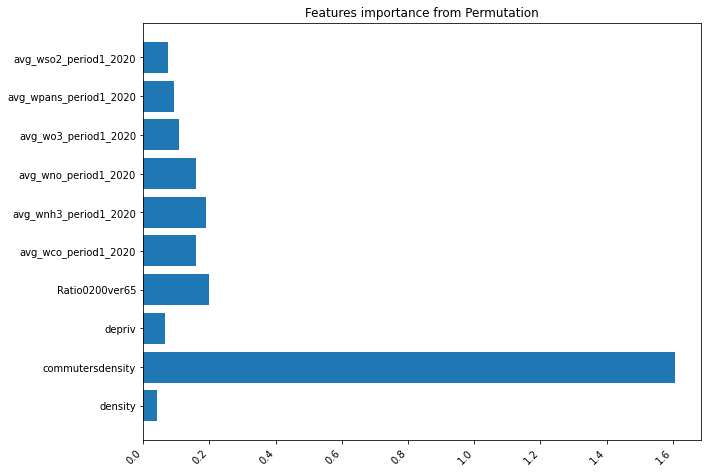

<Figure size 720x720 with 0 Axes>

((0.3603854733480211, 0.02103333718062779),
 (1.020814142834278, 0.08891379494474197),
 0.3562140948134083,
 {'density': 0.015835851871976777,
  'commutersdensity': 0.5940165400001312,
  'depriv': 0.02479629474718485,
  'Ratio0200ver65': 0.07390102773216822,
  'avg_wco_period1_2020': 0.05885744116641377,
  'avg_wnh3_period1_2020': 0.07034020080182654,
  'avg_wno_period1_2020': 0.05928328400592505,
  'avg_wo3_period1_2020': 0.04045817696614547,
  'avg_wpans_period1_2020': 0.03461558793920959,
  'avg_wso2_period1_2020': 0.02789559476901872})

<Figure size 432x288 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.40490  0.02625 
    Test set average RMSE:  1.05903  0.12253 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.39493
                       R2:  0.92863


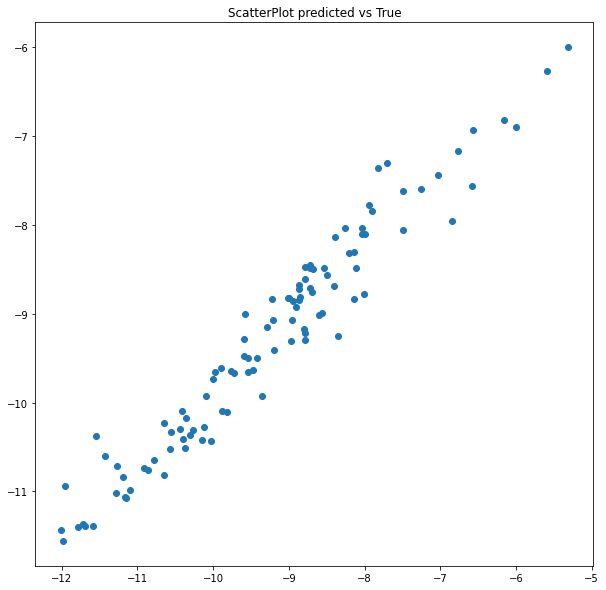

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02757
Feature:                         depriv, Score: 0.20605
Feature:                 Ratio0200ver65, Score: 0.08896
Feature:           avg_wco_period1_2020, Score: 0.15154
Feature:          avg_wnh3_period1_2020, Score: 0.09163
Feature:           avg_wno_period1_2020, Score: 0.24007
Feature:           avg_wo3_period1_2020, Score: 0.08419
Feature:         avg_wpans_period1_2020, Score: 0.05461
Feature:          avg_wso2_period1_2020, Score: 0.05538


<Figure size 432x288 with 0 Axes>

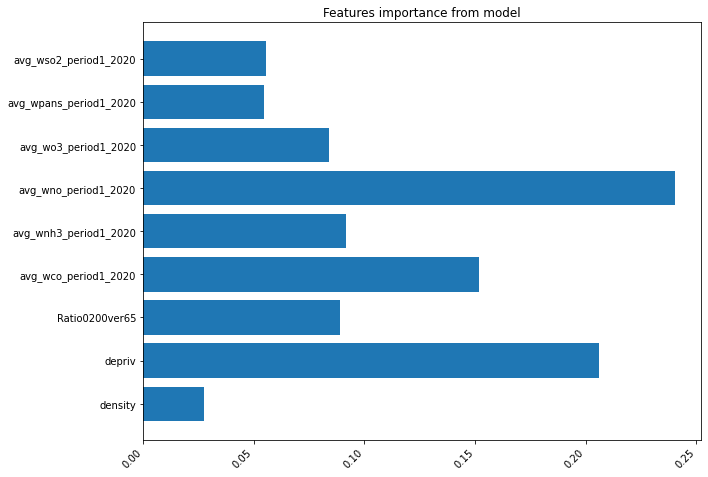

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.05800
Feature:                         depriv, Score: 0.54403
Feature:                 Ratio0200ver65, Score: 0.15603
Feature:           avg_wco_period1_2020, Score: 0.21735
Feature:          avg_wnh3_period1_2020, Score: 0.28127
Feature:           avg_wno_period1_2020, Score: 0.61303
Feature:           avg_wo3_period1_2020, Score: 0.12635
Feature:         avg_wpans_period1_2020, Score: 0.14035
Feature:          avg_wso2_period1_2020, Score: 0.10079


<Figure size 432x288 with 0 Axes>

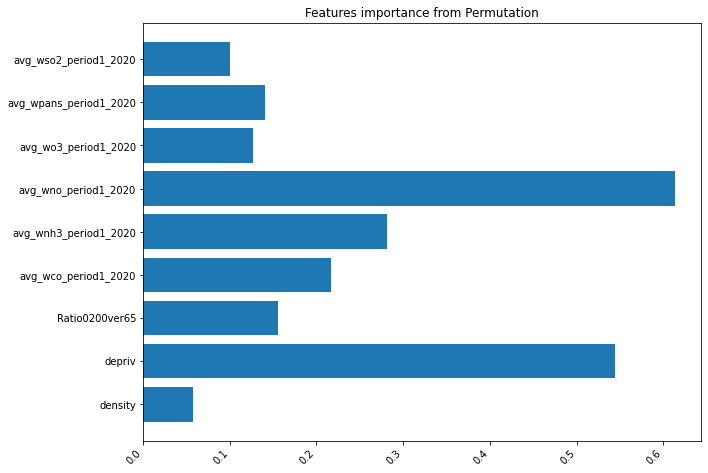

<Figure size 720x720 with 0 Axes>

((0.4048957267508749, 0.026254617998114235),
 (1.0590290932148585, 0.12253234541508663),
 0.3949299568971731,
 {'density': 0.025925829246136695,
  'depriv': 0.2431740123148048,
  'Ratio0200ver65': 0.06974473187303813,
  'avg_wco_period1_2020': 0.09715198027227069,
  'avg_wnh3_period1_2020': 0.1257229271157662,
  'avg_wno_period1_2020': 0.27401444943496495,
  'avg_wo3_period1_2020': 0.056478783209845666,
  'avg_wpans_period1_2020': 0.06273518842614913,
  'avg_wso2_period1_2020': 0.04505209810702371})

<Figure size 432x288 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocommut", pout=sys.stdout, showplot=True)

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.155969670854803
2  of  1200 MSE:  0.15370963284083397
3  of  1200 MSE:  0.22859035965162813
4  of  1200 MSE:  0.26844913510933355
5  of  1200 MSE:  0.5321912379002136
6  of  1200 MSE:  0.6116979426633868
7  of  1200 MSE:  0.8199347169423283
8  of  1200 MSE:  0.8691472080659786
9  of  1200 MSE:  0.208899389791145
10  of  1200 MSE:  0.2399470922134911
11  of  1200 MSE:  0.25528245540945604
12  of  1200 MSE:  0.29454094086343985
13  of  1200 MSE:  0.5321912379002136
14  of  1200 MSE:  0.6116979426633868
15  of  1200 MSE:  0.8199347169423283
16  of  1200 MSE:  0.8691472080659786
17  of  1200 MSE:  0.3380624843558216
18  of  1200 MSE:  0.40198196354887206
19  of  1200 MSE:  0.3795253477237476
20  of  1200 MSE:  0.4561503512950881
21  of  1200 MSE:  0.5321912379002136
22  of  1200 MSE:  0.6116979426633868
23  of  1200 MSE:  0.8199347169423283
24  of  1200 MSE:  0.8691472080659786
25  of  1200 MSE:  0.4829500917215024
26  of  1200 MSE:  0.5583174782162034
27  of  1200 MSE:

Training set average RMSE:  0.37952  0.02625 
    Test set average RMSE:  1.05726  0.11296 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.37523
                       R2:  0.93557


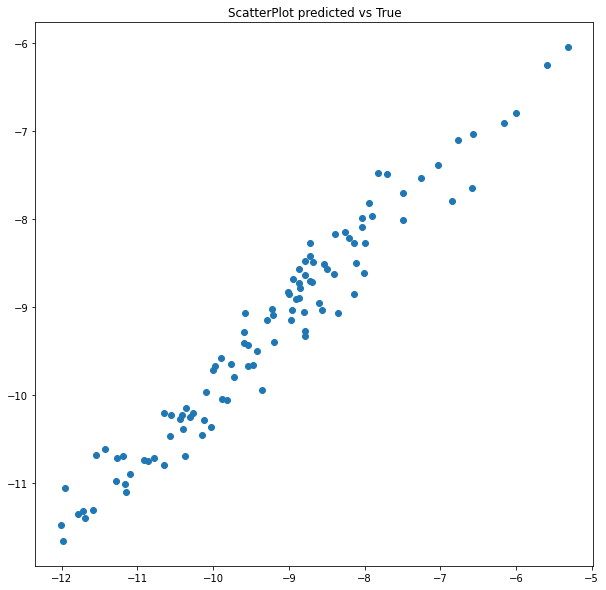

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04584
Feature:                         depriv, Score: 0.16228
Feature:                 Ratio0200ver65, Score: 0.07670
Feature:           avg_wco_period1_2020, Score: 0.16013
Feature:          avg_wnh3_period1_2020, Score: 0.12212
Feature:           avg_wno_period1_2020, Score: 0.19849
Feature:           avg_wo3_period1_2020, Score: 0.11210
Feature:         avg_wpans_period1_2020, Score: 0.05521
Feature:          avg_wso2_period1_2020, Score: 0.06713


<Figure size 432x288 with 0 Axes>

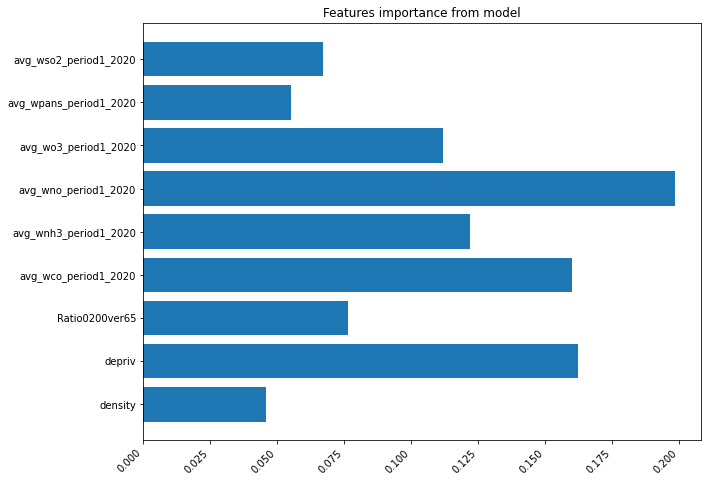

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04019
Feature:                         depriv, Score: 0.48033
Feature:                 Ratio0200ver65, Score: 0.14704
Feature:           avg_wco_period1_2020, Score: 0.37027
Feature:          avg_wnh3_period1_2020, Score: 0.26565
Feature:           avg_wno_period1_2020, Score: 0.53288
Feature:           avg_wo3_period1_2020, Score: 0.15687
Feature:         avg_wpans_period1_2020, Score: 0.15666
Feature:          avg_wso2_period1_2020, Score: 0.10570


<Figure size 432x288 with 0 Axes>

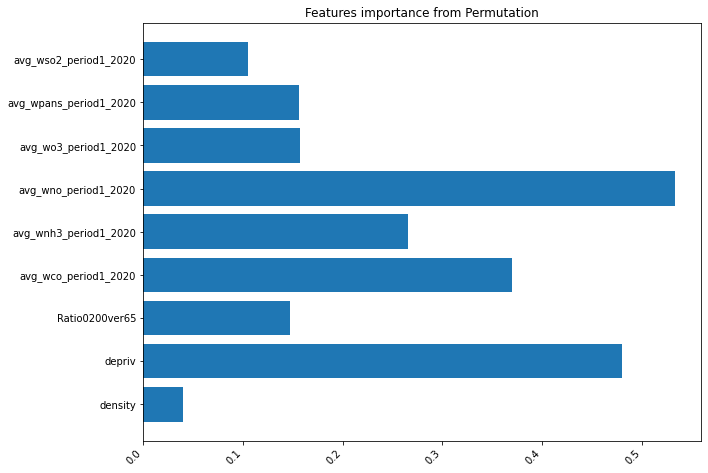

<Figure size 720x720 with 0 Axes>

((0.37952408633092394, 0.026251219188390133),
 (1.0572619130598497, 0.1129613886795429),
 0.3752315989350743,
 {'density': 0.017818932084517743,
  'depriv': 0.21295026390501814,
  'Ratio0200ver65': 0.06519042591055701,
  'avg_wco_period1_2020': 0.16415589138000405,
  'avg_wnh3_period1_2020': 0.11777473570829702,
  'avg_wno_period1_2020': 0.23624763794140846,
  'avg_wo3_period1_2020': 0.06954721577398314,
  'avg_wpans_period1_2020': 0.06945270207889481,
  'avg_wso2_period1_2020': 0.046862195217319574})

<Figure size 432x288 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocommut_opt", showplot=True, optimisedparams=bestf)